# Chapter 17

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    
try:
    import modsim
except ImportError:
    !pip install modsimpy

**Pharmacokinetics** is the study of how drugs and other substances move around the body, react, and are eliminated. In this chapter, we
implement one of the most widely used pharmacokinetic models: the
so-called **minimal model** of glucose and insulin in the blood stream.

My presentation in this chapter follows Bergman (2005) "Minimal Model"
(abstract at <http://modsimpy.com/bergman>, PDF at
<http://modsimpy.com/minmod>).

## The glucose-insulin system

**Glucose** is a form of sugar that circulates in the blood of animals; it is used as fuel for muscles, the brain, and other organs. The concentration of blood sugar is controlled by the hormone system, and especially by **insulin**, which is produced by the pancreas and has the effect of reducing blood sugar.

In people with normal pancreatic function, the hormone system maintains **homeostasis**; that is, it keeps the concentration of blood sugar in a range that is neither too high or too low.

But if the pancreas does not produce enough insulin, or if the cells
that should respond to insulin become insensitive, blood sugar can
become elevated, a condition called **hyperglycemia**. Long term, severe hyperglycemia is the defining symptom of **diabetes mellitus**, a serious disease that affects almost 10% of the population in the U.S. (see <http://modsimpy.com/cdc>).

One of the most-used tests for hyperglycemia and diabetes is the
frequently sampled intravenous glucose tolerance test (FSIGT), in which glucose is injected into the blood stream of a fasting subject (someone who has not eaten recently); then blood samples are collected at intervals of 2--10 minutes for 3 hours. The samples are analyzed to
measure the concentrations of glucose and insulin.

By analyzing these measurements, we can estimate several parameters of
the subject's response; the most important is a parameter denoted $S_I$, which quantifies the effect of insulin on the rate of reduction in blood sugar.

## The glucose minimal model

The "minimal model", as proposed by Bergman, Ider, Bowden, and
Cobelli, consists of two parts: the glucose model and the insulin model. I will present an implementation of the glucose model; as a case study, you will have the chance to implement the insulin model.

The original model was developed in the 1970s; since then, many
variations and extensions have been proposed. Bergman's comments on the development of the model provide insight into their process:

> We applied the principle of Occam's Razor, i.e. by asking what was the simplest model based upon known physiology that could account for the insulin-glucose relationship revealed in the data. Such a model must be simple enough to account totally for the measured glucose (given the insulin input), yet it must be possible, using mathematical techniques, to estimate all the characteristic parameters of the model from a single data set (thus avoiding unverifiable assumptions).

The most useful models are the ones that achieve this balance: including enough realism to capture the essential features of the system without so much complexity that they are impractical. In this example, the practical limit is the ability to estimate the parameters of the model using data, and to interpret the parameters meaningfully.

Bergman discusses the features he and his colleagues thought were
essential:

> (1) Glucose, once elevated by injection, returns to basal level due to two effects: the effect of glucose itself to normalize its own concentration \[...\] as well as the catalytic effect of insulin to allow glucose to self-normalize (2) Also, we discovered that the effect of insulin on net glucose disappearance must be sluggish --- that is, that insulin acts slowly because insulin must first move from plasma to a remote compartment \[...\] to exert its action on glucose disposal.

To paraphrase the second point, the effect of insulin on glucose
disposal, as seen in the data, happens more slowly than we would expect if it depended primarily on the the concentration of insulin in the blood. Bergman's group hypothesized that insulin must move relatively slowly from the blood to a "remote compartment" where it has its effect.

At the time, the remote compartment was a modeling abstraction that
might, or might not, represent something physical. Later, according to
Bergman, it was "shown to be interstitial fluid", that is, the fluid
that surrounds tissue cells. In the history of mathematical modeling, it is common for hypothetical entities, added to models to achieve
particular effects, to be found later to correspond to physical
entities.

The glucose model consists of two differential equations:

$$\frac{dG}{dt} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t)$$

$$\frac{dX}{dt} = k_3 \left[I(t) - I_b \right] - k_2 X(t)$$ 

where

-   $G$ is the concentration of blood glucose as a function of time and $dG/dt$ is its rate of change.

-   $X$ is the concentration of insulin in the tissue fluid as a
    function of time, and $dX/dt$ is its rate of change.

-   $I$ is the concentration of insulin in the blood as a function of
    time, which is taken as an input into the model, based on
    measurements.

-   $G_b$ is the basal concentration of blood glucose and $I_b$ is the
    basal concentration of blood insulin, that is, the concentrations at equilibrium. Both are constants estimated from measurements at the
    beginning or end of the test.

-   $k_1$, $k_2$, and $k_3$ are positive-valued parameters that control the rates of appearance and disappearance for glucose and insulin.

We can interpret the terms in the equations one by one:

-   $-k_1 \left[ G(t) - G_b \right]$ is the rate of glucose
    disappearance due to the effect of glucose itself. When $G(t)$ is
    above basal level, $G_b$, this term is negative; when $G(t)$ is
    below basal level this term is positive. So in the absence of
    insulin, this term tends to restore blood glucose to basal level.

-   $-X(t) G(t)$ models the interaction of glucose and insulin in tissue
    fluid, so the rate increases as either $X$ or $G$ increases. This
    term does not require a rate parameter because the units of $X$ are
    unspecified; we can consider $X$ to be in whatever units make the
    parameter of this term 1.

-   $k_3 \left[ I(t) - I_b \right]$ is the rate at which insulin
    diffuses between blood and tissue fluid. When $I(t)$ is above basal
    level, insulin diffuses from the blood into the tissue fluid. When
    $I(t)$ is below basal level, insulin diffuses from tissue to the
    blood.

-   $-k_2 X(t)$ is the rate of insulin disappearance in tissue fluid as
    it is consumed or broken down.

The initial state of the model is $X(0) = I_b$ and $G(0) = G_0$, where
$G_0$ is a constant that represents the concentration of blood sugar
immediately after the injection. In theory we could estimate $G_0$ based on measurements, but in practice it takes time for the injected glucose to spread through the blood volume. Since $G_0$ is not measurable, it is treated as a **free parameter** of the model, which means that we are free to choose it to fit the data.

## Data

To develop and test the model, we'll use data from Pacini and Bergman, "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test", *Computer Methods and Programs in Biomedicine*, 23: 113-122, (1986).

The following cell reads the data.

In [2]:
import os

filename = 'glucose_insulin.csv'

if not os.path.exists(filename):
    !wget https://raw.githubusercontent.com/AllenDowney/ModSimPy/master/data/glucose_insulin.csv

We can use Pandas to read the data file.

In [3]:
from pandas import read_csv

data = read_csv('glucose_insulin.csv', index_col='time')
data.head()

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51


`data` has two columns: `glucose` is the concentration of blood glucose in mg/dL; `insulin` is concentration of insulin in the blood in μU/mL (a medical "unit", denoted U, is an amount defined by convention in context). The index is time in minutes.

This dataset represents glucose and insulin concentrations over
182 min for a subject with normal insulin production and sensitivity.

## Interpolation

Before we are ready to implement the model, there's one problem we have to solve. In the differential equations, $I$ is a function that can be evaluated at any time, $t$. But in the `DataFrame`, we only have measurements at discrete times. This is a job for interpolation!

The ModSim library provides a function named `interpolate`, which is a
wrapper for the SciPy function `interp1d`. It takes any kind of `Series` as a parameter, including `TimeSeries` and `SweepSeries`, and returns a function. That's right, I said it returns a *function*.

So we can call `interpolate` like this:

In [4]:
from modsim import interpolate

I = interpolate(data.insulin)

Then we can call the new function, `I`, like this:

In [5]:
I(18)

array(31.66666667)

The result is 31.66, which is a linear interpolation between the actual measurements at `t=16` and `t=19`. 

We can also pass an array as an argument to `I`.  Here's an array of equally-spaced values from `t_0` to `t_end`.

In [16]:
from modsim import linrange

t_0 = data.index[0]
t_end = data.index[-1]
t_array = linrange(t_0, t_end)

And here are the corresponding values of `I`.

In [17]:
I_array = I(t_array)

Here's what the interpolated values look like along with the data.

`interpolate` can take additional arguments, which it passes along to
`interp1d`. You can read about these options at
<http://modsimpy.com/interp>.

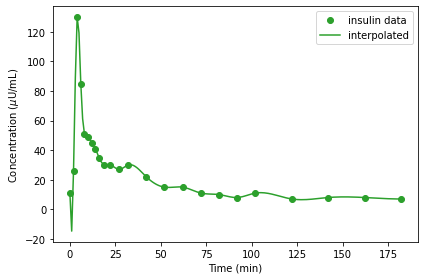

In [18]:
from matplotlib.pyplot import plot
from modsim import decorate

data.insulin.plot(style='o', color='C2', label='insulin data')
plot(t_array, I_array, color='C2', label='interpolated')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

## Summary

In the next chapter, we will use interpolated data to run the simulation
of the glucose-insulin system.



[^1]: Bergman RN, Ider YZ, Bowden CR, Cobelli C., "Quantitative
    estimation of insulin sensitivity\", Am J Physiol. 1979
    Jun;236(6):E667-77. Abstract at <http://modsimpy.com/insulin>.

[^2]: "MINMOD: A computer program to calculate insulin sensitivity and
    pancreatic responsivity from the frequently sampled intravenous
    glucose tolerance test\", *Computer Methods and Programs in
    Biomedicine* 23: 113-122, 1986.

## Exercises

**Exercise:** Read the documentation of `scipy.interpolate.interp1d` at <https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html>.  Pass a keyword argument to `interpolate` to specify one of the other kinds of interpolation, and run the code again to see what it looks like. 

In [24]:
# Solution

I = interpolate(data.insulin, kind='cubic')
I_array = I(t_array)

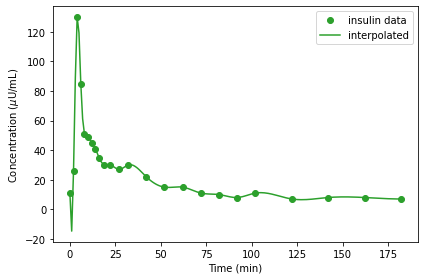

In [25]:
data.insulin.plot(style='o', color='C2', label='insulin data')
plot(t_array, I_array, color='C2', label='interpolated')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

**Exercise:** Interpolate the glucose data and generate a plot, similar to the previous one, that shows the data points and the interpolated curve evaluated at the time values in `ts`.

In [26]:
# Solution

G = interpolate(data.glucose)
G_array = G(t_array)

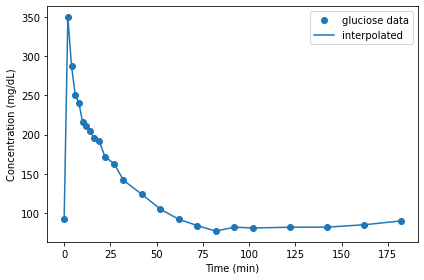

In [27]:
data.glucose.plot(style='o', color='C0', label='gluciose data')
plot(t_array, G_array, color='C0', label='interpolated')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

### Under the hood

In [29]:
%psource interpolate